In [1]:
!pip install missingno MissForest lazypredict



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from missforest import MissForest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import (
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error
)

import warnings
warnings.filterwarnings("ignore")






# Análisis Exploratorio de Datos (EDA) - AB_NYC_2019

En este notebook vamos a:

1. Cargar y explorar los datos.
2. Eliminar columnas inútiles (constantes).
3. Revisar y tratar duplicados.
4. Analizar valores faltantes y decidir qué hacer.
5. Filtrar datos extremos (price, minimum_nights).
6. Detectar outliers (Isolation Forest).
7. Preparar datos para modelado:
   - Train/Test split
   - Imputación de nulos (MissForest)
   - Codificación de categóricas (OneHotEncoder)
   - Escalado de variables (StandardScaler)
8. Hacer un modelo básico de Random Forest y ver importancia de variables.

Al final hay una sección marcada como **EXTRA / OPCIONAL** con cosas más avanzadas.


Cargar los datos

In [2]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.set_index('id', inplace=True)
pd.set_option('display.max_columns', None)
df.head()




,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df.shape

(48895, 15)

## Columnas con un solo valor (constantes)


In [4]:
unicos = df.nunique()  ##calcular nuemeros de valores unicos
unicos



name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [5]:
unicos[unicos == 1] ###ver columnas constantes

Series([], dtype: int64)

In [7]:
# eliminar valores constantes
cols_constantes = unicos[unicos == 1].index.tolist()
df = df.drop(columns=cols_constantes)

print("Columnas eliminadas por ser constantes:", cols_constantes)
df.shape


Columnas eliminadas por ser constantes: []


(48895, 15)

## Duplicados


In [8]:
df.duplicated().sum() #duplicados de filas


np.int64(0)

In [9]:
#duplicados de columnas
df.T.duplicated().sum()


np.int64(0)

In [10]:
#ver duplicadas si hay
df.T[df.T.duplicated(keep=False)]


id,2539,2595,3647,3831,5022,5099,5121,5178,5203,5238,5295,5441,5803,6021,6090,6848,7097,7322,7726,7750,7801,8024,8025,8110,8490,8505,8700,9357,9518,9657,9668,9704,9782,9783,10452,10962,11452,11708,11943,12048,12192,12299,12303,12318,12343,12627,12937,12940,13050,13394,13808,14287,14290,14314,14322,14377,14991,15220,15338,15341,15385,15396,15711,16326,16338,16421,16458,16580,16595,16821,16974,17037,17092,17693,17747,18127,18152,18198,18590,18728,18764,19159,19169,19282,19319,19601,19812,20299,20300,20611,20724,20734,20755,20853,20913,21293,21456,21644,21794,22911,22918,23135,23501,23686,24143,24285,25235,25406,25696,26012,26362,26520,26559,26785,26933,26954,26969,27006,27385,27531,27644,27659,27759,27883,28321,28396,28907,29012,29013,29455,29628,29683,30031,30927,31130,31555,31902,31994,32023,32037,32100,32289,32331,32363,32965,32969,33009,33014,33223,34760,35526,36121,36133,36442,36647,36703,36934,38638,38663,39267,39282,39593,39704,40039,40453,41348,41513,42580,42729,42882,43957,44096,44161,44212,44221,44229,44288,44506,45393,45542,45556,45910,45936,45940,46544,46723,46911,47199,47362,47370,47926,48719,50447,51438,51485,51572,51850,53137,53196,53469,53470,53477,54158,54453,54466,54508,54544,54626,54860,55467,55498,55668,55737,55959,55982,56467,56525,56859,57166,57297,57468,57618,57740,57754,57874,58059,58062,58467,59014,59121,59642,59709,59855,60164,60457,60611,60666,60673,60680,60794,60948,61167,61224,61406,61492,61509,62095,62427,62430,62452,62461,62787,62891,62903,62925,63299,63320,63360,63546,63573,63588,63610,63657,63693,63719,63913,64000,64015,64107,64277,64314,64365,64707,64837,65019,65268,65556,65562,65615,65660,65813,65834,66008,66026,66251,66275,66451,66718,66741,66974,67288,67299,67397,68099,68305,68403,68735,68765,68900,68974,69894,69921,70095,70128,70609,71010,71248,71366,71384,71812,72190,72265,74073,74240,74333,74404,74680,74860,75193,75635,76761,77765,77936,78919,79067,79782,80493,80684,80700,80924,81739,82549,82550,82638,82928,83243,83446,83722,83847,84010,84059,84659,84905,85094,86215,89427,89621,93313,94035,94209,94477,94783,95747,95883,96471,98330,98663,99070,99085,100002,100184,100186,101053,102995,103161,103311,103806,105469,105510,106363,106647,107630,107895,110739,112100,112304,112359,112435,113265,113945,114123,114229,114969,115535,115678,115748,116940,117425,118061,118430,118680,120362,121687,121861,123784,125053,125163,125594,126443,126816,127387,128975,131154,132516,132570,132695,133025,134934,135393,135465,135706,136493,138216,139624,140133,140425,140973,141154,141335,141890,141984,142069,144087,144148,145064,145188,145994,146754,147586,148201,148259,148825,149287,149777,150804,151199,151478,152071,152078,152259,152263,152520,153405,153780,154934,155296,157673,158061,158176,158290,158913,158955,159749,159815,159913,160609,160994,161366,161394,161996,162493,162508,163627,163809,163814,163836,164989,165080,165461,165824,166006,166172,166541,166983,167013,167017,167222,167482,168084,168123,168546,168810,169002,169152,169306,169464,169483,170420,170761,171776,172700,172870,173072,173151,173742,174527,174966,176135,176653,176962,177421,177495,177606,179670,179741,180507,180792,181972,182069,182095,182177,182649,185266,187488,187566,187986,188146,188661,188674,189135,189181,189732,189787,190267,190542,190968,190974,191075,193105,193333,193393,193853,194154,195123,195233,195240,195578,195971,195989,196010,197155,197753,197942,199195,199312,200645,200955,201992,202273,203901,204065,204833,204959,205043,205485,205735,205867,206071,206316,206772,206957,208148,208889,209310,211078,211974,212109,212178,212544,213272,213330,214917,215560,215784,215907,217580,218358,219066,219482,219793,219818,219922,220351,220563,220946,221043,221097,221618,222054,222304,223930,224004,224006,224510,225297,225306,225887,225926,225976,226021,227715,227735,228317,228496,228517,228925,228979,229367,229874,230321,230854,230877,230956,231414,232612,232618,233189,233638,233662,234184,234870,235552,235651,235951,235960,236671,236788,2

## Valores faltantes

Vamos a:

1. Ver el porcentaje de nulos por columna.
2. Eliminar las columnas con demasiados nulos (> 40%).
3. Analizar filas con nulos y visualizarlos.


In [11]:
#procentaje de nulos
missing_perc = df.isna().mean().sort_values(ascending=False)
missing_perc


reviews_per_month                 0.205583
last_review                       0.205583
host_name                         0.000429
name                              0.000327
neighbourhood                     0.000000
neighbourhood_group               0.000000
host_id                           0.000000
longitude                         0.000000
latitude                          0.000000
room_type                         0.000000
price                             0.000000
number_of_reviews                 0.000000
minimum_nights                    0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [12]:
# eliminar con muchos nulos
threshold = 0.4  # 40%
cols_high_na = missing_perc[missing_perc > threshold].index.tolist()

df = df.drop(columns=cols_high_na)

print("Columnas eliminadas por tener más del 40% de nulos:", cols_high_na)
df.shape


Columnas eliminadas por tener más del 40% de nulos: []


(48895, 15)

In [13]:
#filas con nulos
df.isnull().any(axis=1).sum()


np.int64(10074)

In [14]:
# ver filas con exactamente N nulos
n = 2
df[df.isnull().sum(axis=1) == n]


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27


<Axes: >

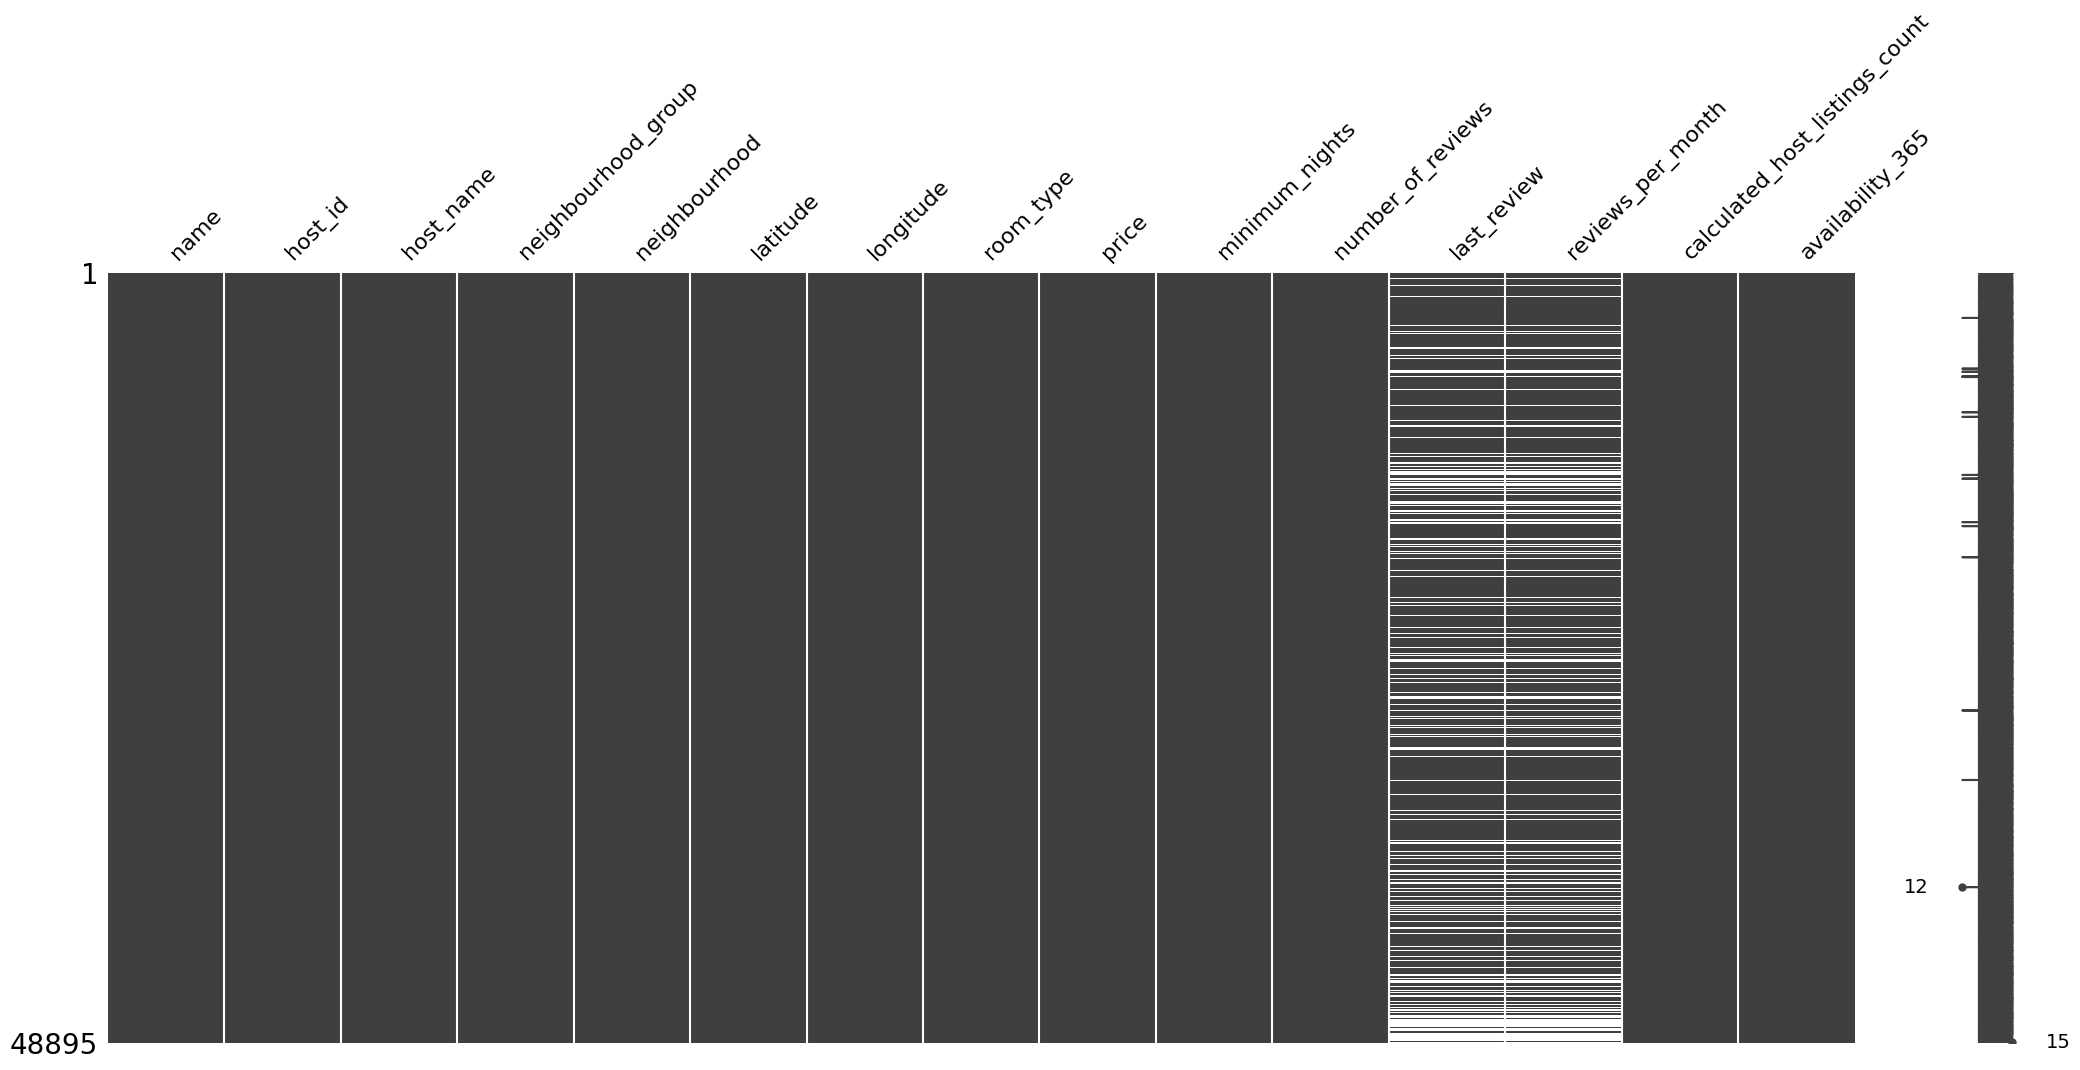

In [15]:
# visualizacion de nulos
msno.matrix(df)


Filtrar valores extremos basicos
## Filtrado básico de registros

Filtramos:

- `price` >= 10  
- `minimum_nights` <= 25


In [16]:
# filtro "price"
df = df[df["price"] >= 10]
df.shape


(48884, 15)

In [17]:
# filtro minimum_nights
df = df[df["minimum_nights"] <= 25]
df.shape


(43803, 15)

OUTLIERS
## Outliers

Vamos a usar **Isolation Forest** sobre las variables numéricas para detectar posibles outliers.


In [18]:
#seleccionar numericas para Isolation Forest
df_num = df.select_dtypes(include=np.number)
df_num.head()


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
2539,2787,40.64749,-73.97237,149,1,9,0.21,6,365
2595,2845,40.75362,-73.98377,225,1,45,0.38,2,355
3647,4632,40.80902,-73.94190,150,3,0,NaN,1,365
3831,4869,40.68514,-73.95976,89,1,270,4.64,1,194
5022,7192,40.79851,-73.94399,80,10,9,0.10,1,0


In [21]:
# isolation forest
iso = IsolationForest(random_state=42, contamination=0.01)
y_pred_if = iso.fit_predict(df_num)

df["anomaly_if"] = y_pred_if  # 1 = normal, -1 = outlier

df["anomaly_if"].value_counts()


anomaly_if
 1    43364
-1      439
Name: count, dtype: int64

OPCIONAL : eliminar outliers detectados


In [22]:
df = df[df["anomaly_if"] == 1].drop(columns=["anomaly_if"])
df.shape

(43364, 15)

## Train/Test Split

Definimos:

- Variable objetivo: `price`
- Variables predictoras: algunas numéricas y categóricas relevantes.


In [23]:
# definir X y Y
features = [
    "neighbourhood_group",
    "neighbourhood",
    "latitude",
    "longitude",
    "room_type",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

X = df[features]
y = df["price"]


In [24]:
#train test y split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((34691, 10), (8673, 10))

### Imputación de valores faltantes (MissForest)


In [28]:
# imputar con Miss forest

# Imputación de valores faltantes (solo numéricas) con MissForest

# 1. Separamos columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = [c for c in X.columns if c not in num_cols]

# 2. Creamos los DataFrames numéricos de train y test
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

# 3. Imputamos SOLO las numéricas con MissForest
imp = MissForest()
imp.fit(X_train_num)

X_train_num_imp = imp.transform(X_train_num)
X_test_num_imp = imp.transform(X_test_num)

# 4. Convertimos de nuevo a DataFrame y ponemos los mismos índices
X_train_num_imp = pd.DataFrame(X_train_num_imp, columns=num_cols, index=X_train.index)
X_test_num_imp = pd.DataFrame(X_test_num_imp, columns=num_cols, index=X_test.index)

# 5. Juntamos numéricas imputadas + categóricas originales
X_train_imp = pd.concat([X_train_num_imp, X_train[cat_cols]], axis=1)
X_test_imp = pd.concat([X_test_num_imp, X_test[cat_cols]], axis=1)

X_train_imp.head()






  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 90.92it/s]


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group,neighbourhood,room_type
id,,,,,,,,,,
35059067,40.76444,-73.87238,1,7,5.38,5,73,Queens,East Elmhurst,Private room
7677595,40.67309,-73.96354,3,4,0.09,1,0,Brooklyn,Prospect Heights,Entire home/apt
13486680,40.82882,-73.94148,7,1,0.03,2,0,Manhattan,Harlem,Private room
13153856,40.71233,-73.94806,1,6,0.16,1,0,Brooklyn,Williamsburg,Entire home/apt
17545775,40.71786,-73.94556,2,9,0.33,1,0,Brooklyn,Williamsburg,Entire home/apt


## Codificación de variables categóricas (OneHotEncoder)


In [29]:
cat_cols = ["neighbourhood_group", "neighbourhood", "room_type"]
num_cols = [c for c in X.columns if c not in cat_cols]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(X_train_imp[cat_cols])

X_train_cat = encoder.transform(X_train_imp[cat_cols])
X_test_cat = encoder.transform(X_test_imp[cat_cols])

X_train_num = X_train_imp[num_cols].to_numpy()
X_test_num = X_test_imp[num_cols].to_numpy()

X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



## Escalar variables numéricas (StandardScaler)


In [30]:
# scandar staler
scaler = StandardScaler()
scaler.fit(X_train_final)

X_train_final_scaled = scaler.transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

X_train_final_scaled[:3]


array([[ 6.54763017e-01,  1.69406202e+00, -6.91015847e-01,
        -3.97802202e-01,  2.73385067e+00,  1.25333291e+00,
        -2.05003967e-01, -1.55204900e-01, -8.65181083e-01,
        -8.53017844e-01,  2.71651773e+00, -8.90611930e-02,
        -2.68545660e-02, -9.29974407e-03, -2.21422876e-02,
        -4.09231391e-02, -1.40441062e-01, -2.21422876e-02,
        -3.52285804e-02, -5.29523790e-02, -9.29974407e-03,
        -1.31523930e-02, -2.73867862e-02, -1.86019015e-02,
        -2.93073812e-01, -1.31523930e-02, -1.69806455e-02,
        -2.14808645e-02, -4.05682339e-02, -1.20062641e-02,
        -5.98935421e-02, -5.43039077e-02, -9.29974407e-03,
        -3.56363750e-02, -4.05682339e-02, -1.93617521e-02,
        -5.61420408e-02, -3.83703841e-02, -7.59309979e-03,
        -2.35985412e-01, -2.57572518e-02, -6.01354332e-02,
        -7.26222176e-02, -1.31523930e-02, -5.36905497e-03,
        -1.47838810e-01, -9.13348414e-02, -1.78097080e-02,
        -3.31147422e-02, -2.51907259e-02, -2.21422876e-0

## Modelo básico: Random Forest y Feature Importance


In [31]:
# entrenar Randomforest y ver importancia
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_final_scaled, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 10 características más importantes:\n")
for i in range(10):
    print(f"{i+1}. Índice {indices[i]} - Importancia: {importances[indices[i]]:.4f}")


Top 10 características más importantes:

1. Índice 1 - Importancia: 0.2289
2. Índice 0 - Importancia: 0.1522
3. Índice 4 - Importancia: 0.1332
4. Índice 6 - Importancia: 0.0986
5. Índice 229 - Importancia: 0.0968
6. Índice 2 - Importancia: 0.0619
7. Índice 3 - Importancia: 0.0525
8. Índice 5 - Importancia: 0.0310
9. Índice 18 - Importancia: 0.0270
10. Índice 72 - Importancia: 0.0168


In [ ]:
# evaluacion basica en test
y_pred = rf.predict(X_test_final_scaled)

print("R2:", r2_score(y_test, y_pred))
print("Mediana AE:", median_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))


In [ ]:
# Gráfico y_pred vs y_test
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Random Forest - Predicción vs Real")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.show()
